# Dependencies

In [4]:
import re
import pickle
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")
from PIL import Image
import requests
from io import BytesIO



# Loading the data

In [6]:
books = pd.read_csv(r"/content/drive/MyDrive/datasets/BookRecommendationSystem/Books.csv", delimiter=';', error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)
users = pd.read_csv(r"/content/drive/MyDrive/datasets/BookRecommendationSystem/Users.csv", delimiter=';', error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)
ratings = pd.read_csv(r"/content/drive/MyDrive/datasets/BookRecommendationSystem/Book-Ratings.csv", delimiter=';', error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)

print("Books Data:    ", books.shape)
print("Users Data:    ", users.shape)
print("Books-ratings: ", ratings.shape)

Books Data:     (271360, 8)
Users Data:     (278858, 3)
Books-ratings:  (1149780, 3)


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


📚 there are  3 datasets in the master dataset of book recommendation system

In [8]:
# sample of books dataset
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [9]:
#sample of users dataset
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [10]:
#sample of ratings dataset
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


# Understanding the data

In [11]:
#overview of books data
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [12]:
#overview of users dataset
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [13]:
#overview of ratings dataset
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [14]:
#checking null values in books data
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [15]:
#dropping null values
books.dropna(inplace=True)

In [16]:
#checking null values in users data
users.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

In [17]:
#dropping null values
users.dropna(inplace=True)

In [18]:
#checking null values in ratings dataset
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

# Data cleaning

--------------- USERS----------------

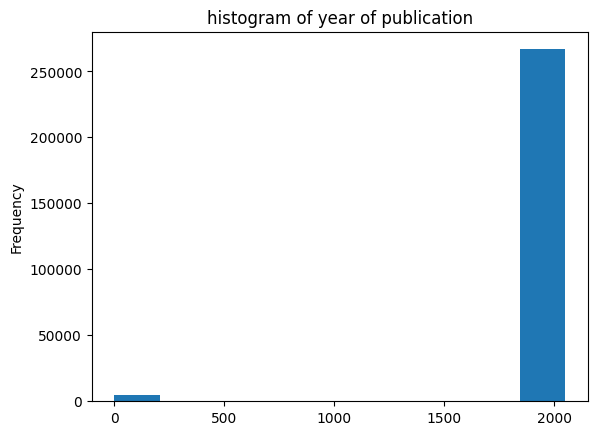

In [19]:
#different year of publications
x=books['Year-Of-Publication'].astype('int')
x.plot.hist(range=(x.min(), x.max()))
plt.title('histogram of year of publication')
plt.show()

There are values of year of publication zero  
There are values of year of publication more than 2021 the present so replacing the values with reasonable values

In [21]:
# replacing the abnormal values
books['Year-Of-Publication']=books['Year-Of-Publication'].astype('int')
books.loc[books['Year-Of-Publication'] > 2021, 'Year-Of-Publication'] = 2002
books.loc[books['Year-Of-Publication'] == 0, 'Year-Of-Publication'] = 2002

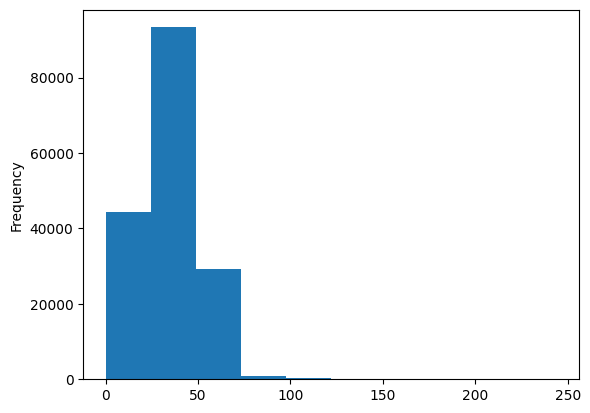

In [20]:
users['Age'].plot.hist()
plt.show()

There are users with age 0  
There are users with age greater than 100

In [22]:
## Uppercasing all alphabets in ISBN
books['ISBN'] = books['ISBN'].str.upper()


In [23]:
## Drop duplicate rows
books.drop_duplicates(keep='first', inplace=True) 
books.reset_index(drop = True, inplace = True)

--------------users--------------

In [24]:
#replacing the abnormal values with the mean value
required = users[users['Age'] <= 80]
required = required[required['Age'] >= 10]
mean = round(required['Age'].mean())   
mean

35

In [25]:
users.loc[users['Age'] > 80, 'Age'] = mean    #outliers with age grater than 80 are substituted with mean 
users.loc[users['Age'] < 10, 'Age'] = mean    #outliers with age less than 10 years are substitued with mean
users['Age'] = users['Age'].fillna(mean)      #filling null values with mean
users['Age'] = users['Age'].astype(int)       #changing Datatype to int

---------books ratings-----------

In [26]:
## Uppercasing all alphabets in ISBN
ratings['ISBN'] = ratings['ISBN'].str.upper()

In [27]:
## Drop duplicate rows
ratings.drop_duplicates(keep='last', inplace=True)
ratings.reset_index(drop=True, inplace=True)

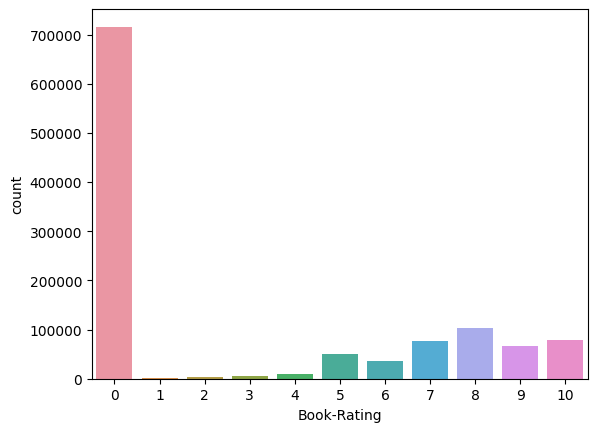

In [28]:
sns.countplot(x='Book-Rating',data=ratings)
plt.show()

There are ratings which are zero i.e. implicit rating 


In [29]:
#seperating implicit and explicit ratings data
ratings = ratings[ratings['Book-Rating']!=0]

In [30]:
#merging the datasets
dataset = pd.merge(books, ratings, on='ISBN', how='inner')
dataset = pd.merge(dataset, users, on='User-ID', how='inner')

In [31]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269659 entries, 0 to 269658
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 269659 non-null  object
 1   Book-Title           269659 non-null  object
 2   Book-Author          269659 non-null  object
 3   Year-Of-Publication  269659 non-null  int64 
 4   Publisher            269659 non-null  object
 5   Image-URL-S          269659 non-null  object
 6   Image-URL-M          269659 non-null  object
 7   Image-URL-L          269659 non-null  object
 8   User-ID              269659 non-null  int64 
 9   Book-Rating          269659 non-null  int64 
 10  Location             269659 non-null  object
 11  Age                  269659 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 26.7+ MB


# Exploratory Data Analysis

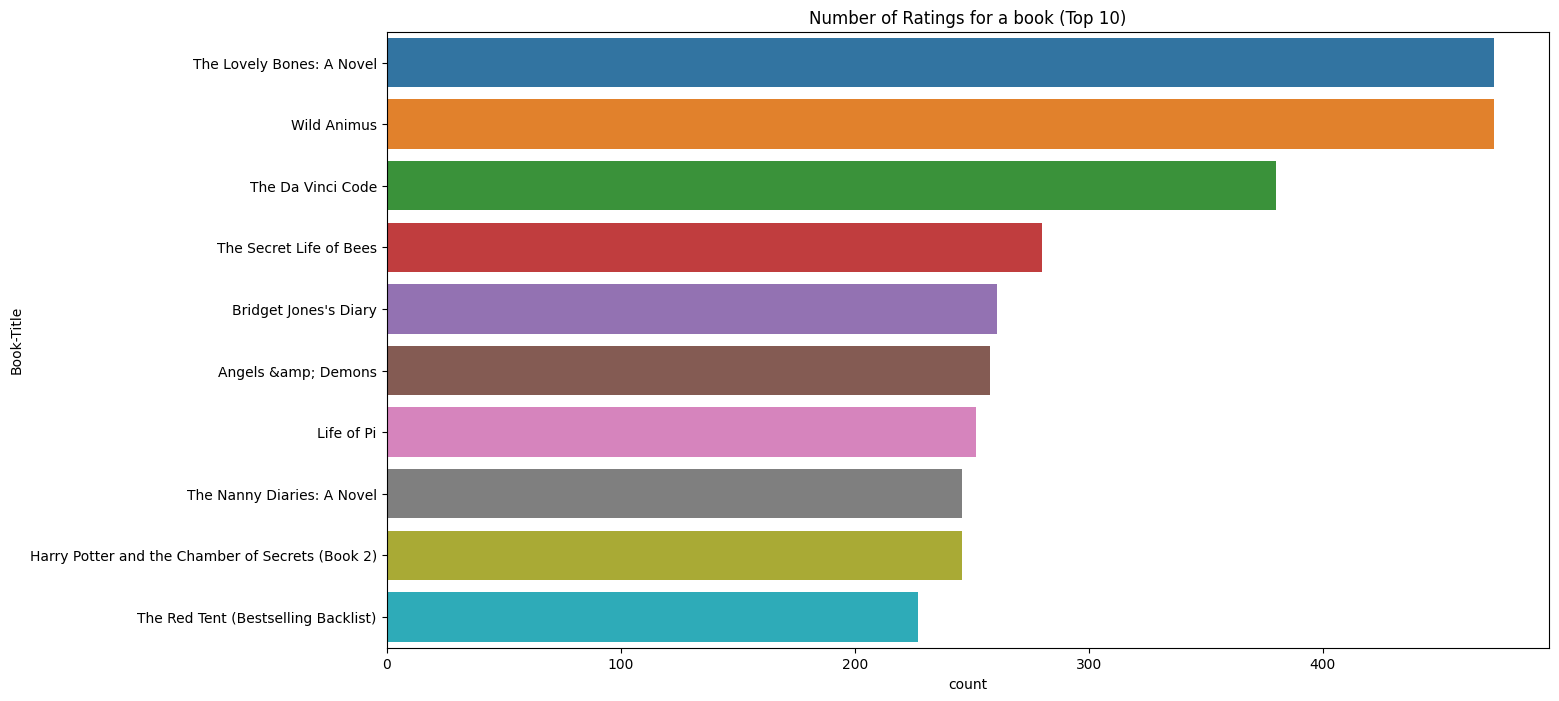

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(y="Book-Title", data=dataset, order=dataset['Book-Title'].value_counts().index[0:10])
plt.title("Number of Ratings for a book (Top 10)")
plt.show()

Text(0.5, 1.0, 'Explicit Ratings')

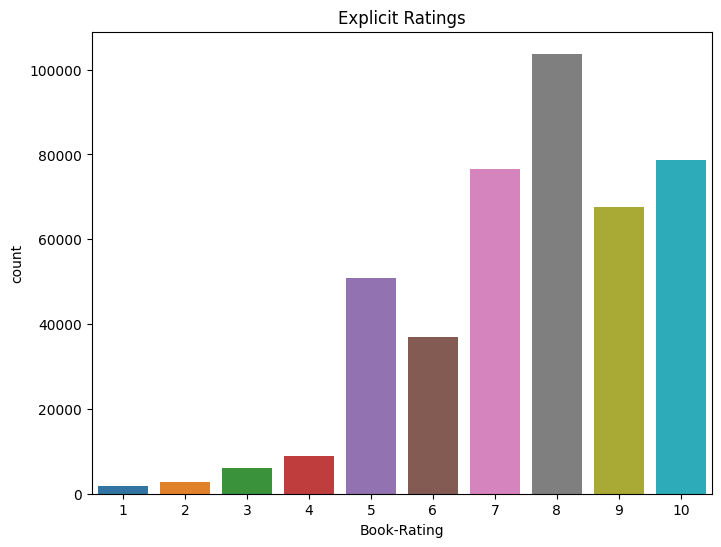

In [32]:
## Explicit Ratings
plt.figure(figsize=(8,6))
data = ratings[ratings['Book-Rating'] != 0]
sns.countplot(x="Book-Rating", data=data)
plt.title("Explicit Ratings")

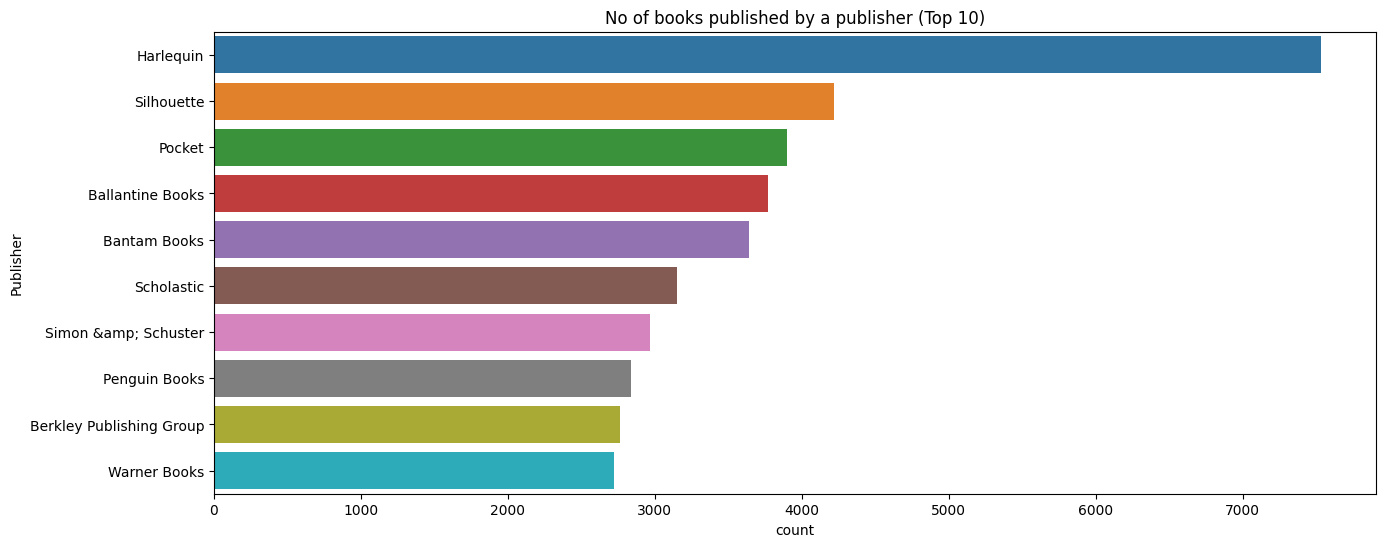

In [33]:
plt.figure(figsize=(15,6))
sns.countplot(y="Publisher", data=books,order=books['Publisher'].value_counts().index[0:10])
plt.title("No of books published by a publisher (Top 10)")
plt.show()

# Recommendation systems

In [34]:
book_title = input('Enter the book name:\n')
number = int(input('Number of books to be recommended:\n'))

Enter the book name:
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Number of books to be recommended:
3


1.Ratings---Popularity based recommendataion

In [35]:
def popularity_based(dataframe, n):
  #this function takes the input of dataset of merged data and
  #the number of top books to be displayed
    if n >= 1 or n <= len(dataframe):
        #creates the dataframe with sum of ratings by ISBN of each book
        data = pd.DataFrame(dataframe.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False).head(n)
        result = pd.merge(data, books, on='ISBN') # merges the books dataframe and sum of ratings dataframe
        return result
    return "Invalid number of books entered!!"

In [36]:
print("Top", number, "Popular books are: ")
datframe= popularity_based(dataset, number)
for i in datframe['Book-Title'].values:
  print(i)

Top 3 Popular books are: 
Wild Animus
The Lovely Bones: A Novel
The Da Vinci Code


2.Books by same author and publisher

In [37]:
def printBook(k, n):
    #storing the unique book titles in z variable
    z = k['Book-Title'].unique()
    for x in range(len(z)): #looping through unique titles until the search reaches given number
        print(z[x])
        if x >= n-1:
            break

In [38]:
def get_books(dataframe, name, n):
  #this function takes the input of merged data
  #input book title and number of books to be displayed
    print("\nBooks by same Author:\n")
    au = dataframe['Book-Author'].unique() # creates a dataframe with unique authors

    data = dataset[dataset['Book-Title'] != name] #slicing the dataframe except the given input title

    if au[0] in list(data['Book-Author'].unique()): # if the author mathes with input book title author
        k2 = data[data['Book-Author'] == au[0]]
    k2 = k2.sort_values(by=['Book-Rating'])
    printBook(k2, n)

    print("\n\nBooks by same Publisher:\n") # if the author mathes with input book title publisher
    au = dataframe['Publisher'].unique()

    if au[0] in list(data['Publisher'].unique()):
        k2 = pd.DataFrame(data[data['Publisher'] == au[0]])
    k2=k2.sort_values(by=['Book-Rating']) 
    printBook(k2, n)

In [39]:
if book_title in list(dataset['Book-Title'].unique()):
    d = dataset[dataset['Book-Title'] == book_title]
    get_books(d, book_title, number)
else:
    print("Invalid Book Name!!")


Books by same Author:

Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Order of the Phoenix (Book 5)
Harry Potter and the Sorcerer's Stone (Book 1)


Books by same Publisher:

The Seeing Stone
The Story of the Seagull and the Cat Who Taught Her To Fly
The Slightly True Story of Cedar B. Hartley: Who Planned to Live an Unusual Life


3.Collaberative filtering

In [40]:
df = pd.DataFrame(dataset['Book-Title'].value_counts())
df['Total-Ratings'] = df['Book-Title']
df['Book-Title'] = df.index
df.reset_index(level=0, inplace=True)
df = df.drop('index',axis=1)

df = dataset.merge(df, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
df = df.drop(['Year-Of-Publication','Publisher','Age','Location'], axis=1)

popularity_threshold = 50
popular_book = df[df['Total-Ratings'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)


User - Item Collaborative Filtering



In [41]:
testdf = pd.DataFrame()
testdf['ISBN'] = popular_book['ISBN']
testdf['Book-Rating'] = popular_book['Book-Rating']
testdf['User-ID'] = popular_book['User-ID']
testdf = testdf[['User-ID','Book-Rating']].groupby(testdf['ISBN'])

In [42]:
listOfDictonaries=[]
indexMap = {}
reverseIndexMap = {}
ptr=0

for groupKey in testdf.groups.keys():
    tempDict={}
    groupDF = testdf.get_group(groupKey)
    for i in range(0,len(groupDF)):
        tempDict[groupDF.iloc[i,0]] = groupDF.iloc[i,1]
    indexMap[ptr]=groupKey
    reverseIndexMap[groupKey] = ptr
    ptr=ptr+1
    listOfDictonaries.append(tempDict)

dictVectorizer = DictVectorizer(sparse=True)
vector = dictVectorizer.fit_transform(listOfDictonaries)
pairwiseSimilarity = cosine_similarity(vector)

In [44]:
def printBookDetails(bookID):
    print(dataset[dataset['ISBN']==bookID]['Book-Title'].values[0])
    """
    print("Title:", dataset1[dataset1['ISBN']==bookID]['Book-Title'].values[0])
    print("Author:",dataset1[dataset['ISBN']==bookID]['Book-Author'].values[0])
    #print("Printing Book-ID:",bookID)
    print("\n")
    """

def getTopRecommandations(bookID):
    collaborative = []
    row = reverseIndexMap[bookID]
    print("Input Book:")
    printBookDetails(bookID)
    
    print("\nRECOMMENDATIONS:\n")
    
    mn = 0
    similar = []
    for i in np.argsort(pairwiseSimilarity[row])[:-2][::-1]:
          if dataset[dataset['ISBN']==indexMap[i]]['Book-Title'].values[0] not in similar:
                if mn>=number:
                      break
                mn+=1
                similar.append(dataset[dataset['ISBN']==indexMap[i]]['Book-Title'].values[0])
                printBookDetails(indexMap[i])
                collaborative.append(dataset[dataset['ISBN']==indexMap[i]]['Book-Title'].values[0])
    return collaborative

In [45]:
k = list(dataset['Book-Title'])
m = list(dataset['ISBN'])

collaborative = getTopRecommandations(m[k.index(book_title)])

Input Book:
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

RECOMMENDATIONS:

Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Order of the Phoenix (Book 5)


Correlation based recommendation

In [46]:
popularity_threshold = 50

user_count = dataset['User-ID'].value_counts()
data = dataset[dataset['User-ID'].isin(user_count[user_count >= popularity_threshold].index)]
rat_count = data['Book-Rating'].value_counts()
data = data[data['Book-Rating'].isin(rat_count[rat_count >= popularity_threshold].index)]

matrix = data.pivot_table(index='User-ID', columns='ISBN', values = 'Book-Rating').fillna(0)

In [47]:
average_rating = pd.DataFrame(dataset.groupby('ISBN')['Book-Rating'].mean())
average_rating['ratingCount'] = pd.DataFrame(ratings.groupby('ISBN')['Book-Rating'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

,Book-Rating,ratingCount
ISBN,,
0316666343,8.243129,707
0971880107,4.477801,581
0385504209,8.434316,487
0312195516,8.255507,383
0060928336,7.945813,320


In [48]:
isbn = books.loc[books['Book-Title'] == book_title].reset_index(drop = True).iloc[0]['ISBN']
row = matrix[isbn]
correlation = pd.DataFrame(matrix.corrwith(row), columns = ['Pearson Corr'])
corr = correlation.join(average_rating['ratingCount'])

res = corr.sort_values('Pearson Corr', ascending=False).head(number+1)[1:].index
corr_books = pd.merge(pd.DataFrame(res, columns = ['ISBN']), books, on='ISBN')
print("\n Recommended Books: \n")
corr_books[['Book-Title','Image-URL-M']]


 Recommended Books: 



,Book-Title,Image-URL-M
0,Harry Potter and the Chamber of Secrets (Book 2),http://images.amazon.com/images/P/0439064872.0...
1,Harry Potter and the Prisoner of Azkaban (Book 3),http://images.amazon.com/images/P/0439136369.0...
2,Harry Potter and the Order of the Phoenix (Boo...,http://images.amazon.com/images/P/043935806X.0...


Content based recommendation

In [50]:
#content based recommendation is executed based on popularity i.e.
# higher than the threshold that is set

popularity_threshold = 80
popular_book = df[df['Total-Ratings'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)
popular_book.shape
popular_book[['Book-Title','Total-Ratings']]

,Book-Title,Total-Ratings
0,White Oleander : A Novel,117
1,The Pilot's Wife : A Novel,166
2,To Kill a Mockingbird,197
3,The Five People You Meet in Heaven,205
4,Deception Point,80
...,...,...
19236,The Fellowship of the Ring (The Lord of the Ri...,152
19237,The Da Vinci Code,380
19238,Dolores Claiborne,93
19239,To Kill a Mockingbird,197


In [51]:

# vectorizing the titles 
tf = TfidfVectorizer(ngram_range=(1, 2), min_df = 1, stop_words='english')
tfidf_matrix = tf.fit_transform(popular_book['Book-Title'])
tfidf_matrix.shape

(19241, 557)

In [52]:
normalized_df = tfidf_matrix.astype(np.float32)
cosine_similarities = cosine_similarity(normalized_df, normalized_df)  #calculating the cosine similarities  for normalized titles with actual titles
cosine_similarities.shape

(19241, 19241)

In [53]:
# a glance at cosine similarities array
cosine_similarities

array([[1.        , 0.06877864, 0.        , ..., 0.        , 0.        ,
        0.04535192],
       [0.06877864, 1.        , 0.        , ..., 0.        , 0.        ,
        0.04240403],
       [0.        , 0.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.99999994, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.04535192, 0.04240403, 0.        , ..., 0.        , 0.        ,
        1.        ]], dtype=float32)

In [54]:
print("Recommended Books:\n")
isbn = books.loc[books['Book-Title'] == book_title].reset_index(drop = True).iloc[0]['ISBN']
content = []

idx = popular_book.index[popular_book['ISBN'] == isbn].tolist()[0]
similar_indices = cosine_similarities[idx].argsort()[::-1]
similar_items = []
for i in similar_indices:
    if popular_book['Book-Title'][i] != book_title and popular_book['Book-Title'][i] not in similar_items and len(similar_items) < number:
        similar_items.append(popular_book['Book-Title'][i])
        content.append(popular_book['Book-Title'][i])

for book in similar_items:
    print(book)

Recommended Books:

Harry Potter and the Sorcerer's Stone (Book 1)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Chamber of Secrets (Book 2)


Hybrid recommendation

In [55]:
z = list()
k = float(1/number)
for x in range(number):
      z.append(1-k*x)

dictISBN = {}
for x in collaborative:
      dictISBN[x] = z[collaborative.index(x)]

for x in content:
    if x not in dictISBN:
        dictISBN[x] = z[content.index(x)]
    else:
        dictISBN[x] += z[content.index(x)]

ISBN = dict(sorted(dictISBN.items(),key=operator.itemgetter(1),reverse=True))
w=0
print("Input Book:\n")
print(book_title)
print("\nRecommended Books:\n")
for x in ISBN.keys():
    if w>=number:
        break
    w+=1
    print(x)

Input Book:

Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

Recommended Books:

Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Sorcerer's Stone (Book 1)
